I was working in Google colab to have more available RAM. 

### Library installation, google drive preparation, library import

In [ ]:
%pip install -U lightgbm==3.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
%pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 399 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [ ]:
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [ ]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("/content/drive/MyDrive/AIproj/git_proj/HM/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

import random
random.seed(42)

In [ ]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    ItemPair,
    UserGroupSaleTrend,
    TimeHistoryDecay,
    SaleTrend,
    OutOfStock,
    ALS,
    BPR,
    UserGroupTimeHistory,
    OrderHistoryDecay,
    TimeHistory,
    ItemCF,
    UserGroupItemCF
)
from src.retrieval.collector import RuleCollector

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale, purhcase_predictors

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
    precision_at_k,
    mean_average_precision,
    
)

In [ ]:
from src.retrieval.rules import (
    OrderHistory,
    ALS,
    BPR,
    UserGroupTimeHistory,
    OrderHistoryDecay,
    ItemPair,
    TimeHistory,
    ItemCF,
    UserGroupItemCF
)

In [ ]:
data_dir = Path("/content/drive/MyDrive/AIproj/data/")
model_dir = Path("/content/drive/MyDrive/AIproj/git_proj/HM/models/")

In [ ]:
# set parameters
TRAIN_WEEK_NUM = 2
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "Recall_1"
TEST = True # * Set as `False` when do local experiments to save time

NUMBER_OF_WEEKS_TOTAL = 25 # total number of weeks that are used for model training

batch_size = 100000 # batch size for Kaggle predictions 

In [ ]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

### Data preparation: encoding ids and preprocessing

In [ ]:
# create an abject to read data 
dh = DataHelper(data_dir)
# data = dh.preprocess_data(save=True, name="encoded_full") # run only once, processed data will be saved
data = dh.load_data(name="encoded_full") # load preprocessed data

In [ ]:
# map ids to a shorter representation 
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [ ]:
# read data 
user = data["user"]
item = data["item"]
inter = data["inter"]

# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
# delete duplicates 
inter = inter.drop_duplicates(['customer_id', 'article_id', 'week'], keep='first') 
# select only NUMBER_OF_WEEKS_TOTAL weeks 
inter = inter.loc[inter['week'] <= NUMBER_OF_WEEKS_TOTAL]
data["inter"] = inter

In [ ]:
# extra preprocessing for users and items 
# calculate purchase_ability of customers based on previous purchases 
user_info = data["inter"].groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')
user_info['purchase_ability'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']
data['user'] = data['user'].merge(user_info, on='customer_id', how='left')

# calculate age bins 
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

user = pd.get_dummies(user, columns=['fashion_news_frequency'])
user = pd.get_dummies(user, columns=['club_member_status'])
user["FN"] = user["FN"].astype('int8')
user["Active"] = user["Active"].astype('int8')

item = pd.get_dummies(item, columns=['index_group_no'])

## Candidate generation for every week 


Generate candidates for training (weeks 1 and more)

In [ ]:
trans = data["inter"]
train['t_dat'] = pd.to_datetime(train['t_dat'])
    
for week in range(1,WEEK_NUM):
    # * use sliding window to generate candidates
    # calculate week dates 
    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    train = train.merge(user_info, on='customer_id', how='left')
    # generate daatsets of transactions for a defined number of weeks 
    last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
    last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
    last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]
    
    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================
    n=50  # number of candidate per strategy per customer 
    # apply different option for candidate generation and their combination using a custom class 'RuleCollector'  
    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=n, scale=True, name='1'),
            OrderHistory(train, days=35, n=n),
            TimeHistory(customer_list, last_week, n=n),
            UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.000,
        compress=False,
    )
    # * ========================== Random Generation ==========================
    # based on notebook from one of the lectures 
    train, valid = dh.split_data(trans, start_date, end_date, valid_is_grouped=False)
    # read all positive pairs during a week
    positive_pairs = list(map(tuple, valid[['customer_id', 'article_id']].drop_duplicates().values))
    n_sample_positive = int(valid.shape[0])
    n_sample = int(n_sample_positive * 1.1)
    cc = valid["customer_id"].unique()
    ac = train.groupby(['article_id'])['customer_id'].count().reset_index()
    # select random customers 
    df_cust=np.random.choice(cc, size=n_sample)
    # select random articles (with number of purchases as weights) 
    df_art=ac.sample(n=n_sample, replace=True, weights='customer_id', axis=0)
    df_art.drop(columns={'customer_id'}, inplace=True)
    # combine customers and articles 
    df_art['customer_id'] = df_cust

    df_art = df_art[
        ~df_art.set_index(["customer_id", "article_id"]).index.isin(positive_pairs)
    ]

    df_art['score'] = 1
    df_art['method'] = 'Random' 
    df_art = df_art.sample(n_sample_positive)
    # =========================================================================
    candidates = df_art
    candidates, _ = reduce_mem_usage(candidates)

    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_random_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

In [ ]:
## run candidate generation for week 0 (not enough memory to run all together) - candidates based on rules
trans = data["inter"]

for week in list(range(1)): 
    # * use sliding window to generate candidates
    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    train = train.merge(user_info, on='customer_id', how='left')

    train['t_dat'] = pd.to_datetime(train['t_dat'])
    last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
    last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
    last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]
    
    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================
    n=50  
    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=n, scale=True, name='1'),
            OrderHistory(train, days=35, n=n),
            TimeHistory(customer_list, last_week, n=n),
            UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.000,
        compress=False,
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 0: [2020-09-23, 2020-09-30)


Retrieve items by rules: 100%|██████████| 5/5 [09:55<00:00, 119.03s/it]


In [ ]:
## run candidate generation for week 0 (not enough memory to run all together) - random candidates
trans = data["inter"]
for week in list(range(1)): 

    # * use sliding window to generate candidates
    
    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    train = train.merge(user_info, on='customer_id', how='left')

    train['t_dat'] = pd.to_datetime(train['t_dat'])

    # * ========================== Random Generation ==========================

    train, valid = dh.split_data(trans, start_date, end_date, valid_is_grouped=False)
    # read all positive pairs during a week
    positive_pairs = list(map(tuple, valid[['customer_id', 'article_id']].drop_duplicates().values))
    n_sample_positive = int(valid.shape[0])
    n_sample = int(n_sample_positive * 1.1)
    cc = valid["customer_id"].unique()
    ac = train.groupby(['article_id'])['customer_id'].count().reset_index()
    # select random customers 
    df_cust=np.random.choice(cc, size=n_sample)
    # select random articles (with number of purchases as weights) 
    df_art=ac.sample(n=n_sample, replace=True, weights='customer_id', axis=0)
    df_art.drop(columns={'customer_id'}, inplace=True)
    # combine customers and articles 
    df_art['customer_id'] = df_cust

    df_art = df_art[
        ~df_art.set_index(["customer_id", "article_id"]).index.isin(positive_pairs)
    ]

    df_art['score'] = 1
    df_art['method'] = 'Random'

    df_art = df_art.sample(n_sample_positive)

    candidates = df_art
    candidates, _ = reduce_mem_usage(candidates)

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_random_candidate.pqt")

Week 0: [2020-09-23, 2020-09-30)


In [ ]:
## combine candidates from two approaches for validation week
week = 0 
candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_random_candidate.pqt")
candidates_nr = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")

customers = candidates_nr.customer_id.unique()
batch_size = 100000
for batch in range(0, len(customers), batch_size):
    print(batch)
    cust = customers[batch : batch + batch_size]

    candidates_nr_b = candidates_nr[candidates_nr['customer_id'].isin(cust)]
    candidates_b = candidates[candidates['customer_id'].isin(cust)]

    candidates_week = candidates_b.append(candidates_nr_b)
    candidates_week, _ = reduce_mem_usage(candidates_week)
    candidates_week = (
        pd.pivot_table(
            candidates_week,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    
    candidates_week.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_batch{batch}_candidate.pqt")

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000


## Feature engineering functions


In [ ]:
def generate_features(inter_rand):
  """ Generate additional features based on transaction history.  
  Parameters
  ----------
  inter_rand : pd.DataFrame 
      Dataframe with transaction history.
  Returns
  -------
  pd.DataFrame 
      Updated dataframe with transaction history and few features.
  """
  inter_rand = inter_rand.merge(data['item'][["article_id", "product_code" ,'index_group_no']], on="article_id", how="left")
  inter_rand['i_pop'] = popularity(inter_rand, 'article_id', week_num=WEEK_NUM)
  inter_rand['p_pop'] = popularity(inter_rand, 'product_code', week_num=WEEK_NUM)
  res = pd.DataFrame(columns=['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'week', 'valid', 'ALS_1', 'ItemCF_2', 'OrderHistoryDecay_1',
       'OrderHistory_1', 'Random', 'TimeHistory_1', 'UGItemCF_2', 'UGItemCF_5',
       'UGTimeHistory_1', 'UGTimeHistory_2', 'product_code', 'index_group_no', 'i_pop', 'p_pop',
       'price_calc', 'purchase_cnt', 'purchase_cnt_cat'])
  inter_rand['t_dat'] = pd.to_datetime(inter_rand["t_dat"])

  for week in tqdm(range(WEEK_NUM)):
      transactions = inter_rand[(inter_rand['week'] >= week) & (inter_rand['week'] < week + 6)]
      max_date = transactions['t_dat'].max()

      transactions['t_dat'] = transactions['t_dat'].fillna(max_date + pd.Timedelta(days=1))
      transactions = purhcase_predictors(transactions, max_date + pd.Timedelta(days=1), train=True)
      res = res.append(transactions)
  gc.collect()

  inter_rand = res
  del res

  inter_rand['i_repurchase_ratio'] = repurchase_ratio(inter_rand, ['article_id'], week_num=WEEK_NUM)
  inter_rand['p_repurchase_ratio'] = repurchase_ratio(inter_rand, ['product_code'], week_num=WEEK_NUM)
  return inter_rand

In [ ]:
def merge_features(inter):
  """ Generate additional features from other sources.  
  Parameters
  ----------
  inter_rand : pd.DataFrame 
      Dataframe with transaction history.
  Returns
  -------
  pd.DataFrame 
      Updated dataframe with few features.
  """
  user_features = ['customer_id', 'FN', 'Active', 'age', 'user_gender',
       'fashion_news_frequency_1', 'fashion_news_frequency_2',
       'fashion_news_frequency_3', 'fashion_news_frequency_4',
       'fashion_news_frequency_5', 'club_member_status_1',
       'club_member_status_2', 'club_member_status_3', 'club_member_status_4']

  item_features = ['article_id', 
       'article_gender', 'season_type', 'index_group_no_1', 'index_group_no_2',
       'index_group_no_3', 'index_group_no_4', 'index_group_no_5']

  inter = inter.merge(user[user_features], on='customer_id', how='left')
  inter = inter.merge(item[item_features], on='article_id', how='left')
     
  return inter

## Feature calculation for validation candidates

In [ ]:
inter['valid'] = 1
inter_sub = inter[inter['week'] <= 10]
inter_sub['t_dat'] = pd.to_datetime(inter_sub["t_dat"])

for batch in range(0, len(submission.customer_id), batch_size):
    print(batch)
    candidates_week = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week0_batch{batch}_candidate.pqt")
    candidates_week['valid'] = 0
    candidates_week['week'] = 0

    candidates_week = pd.concat([inter_sub, candidates_week], ignore_index=True)
    candidates_week = generate_features(candidates_week)
    candidates_week = candidates_week[candidates_week['week'] == 0]
    candidates_week = merge_features(candidates_week)
    candidates_week['purchase_cnt'] = candidates_week['purchase_cnt'].astype(int)
    candidates_week['purchase_cnt_cat'] = candidates_week['purchase_cnt_cat'].astype(int)
    
    candidates_week.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_batch{batch}_candidate_features.pqt")

# Generate candidates for training

Candidates only from OrderHistory_1, TimeHistory_1,  UGTimeHistory_1, and Random group were used to safe time and memory. 

In [ ]:
# read candidates for training 
full_candidates = pd.DataFrame()

for i in tqdm(range(1, WEEK_NUM)):
    week_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    week_candidates['week'] = i
    v = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

    week_candidates = week_candidates[week_candidates['customer_id'].isin(v.customer_id.unique())]
    
    rule_names = ['UGTimeHistory_1', 'OrderHistory_1', 'TimeHistory_1', 'Random']
    tmp = week_candidates[rule_names]
    for f in rule_names:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    week_candidates['score'] = tmp[rule_names].sum(axis=1)
    week_candidates = week_candidates[rule_names + ['score', 'week', 'customer_id', 'article_id']][week_candidates['score'] >= 0]
    week_candidates = week_candidates.drop_duplicates(['customer_id', 'article_id', 'week'], keep='first')
    week_candidates = week_candidates[rule_names + ['score', 'week', 'customer_id', 'article_id']]
    full_candidates = full_candidates.append(week_candidates)
    gc.collect()
    
full_candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"prediction_candidates.pqt")


  0%|          | 0/3 [00:00<?, ?it/s]

week
1    213684
Name: Random, dtype: int64


0

 33%|███▎      | 1/3 [00:09<00:19,  9.90s/it]

week
2    227857
Name: Random, dtype: int64


0

 67%|██████▋   | 2/3 [00:22<00:11, 11.34s/it]

week
3    238006
Name: Random, dtype: int64


0

100%|██████████| 3/3 [00:34<00:00, 11.37s/it]



## Useful functions and constants

In [ ]:
features = [ 'FN',
       'Active', 'age', 'user_gender', 'fashion_news_frequency_1',
       'fashion_news_frequency_2', 'fashion_news_frequency_3',
       'fashion_news_frequency_4', 'fashion_news_frequency_5',
       'club_member_status_1', 'club_member_status_2', 'club_member_status_3',
       'club_member_status_4', 'i_repurchase_ratio', 'p_repurchase_ratio', 
       'season_type', 'index_group_no_1', 'index_group_no_2',
       'index_group_no_3', 'index_group_no_4', 'index_group_no_5', 
       'i_pop', 'p_pop', 'purchase_cnt', 'purchase_cnt_cat'
       ]

params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,
    "verbose": -1,
    "eval_at": 12,
}

In [ ]:
def sample_generation(candidates, inter, name):
    """ Generate samnple for training.
    Parameters
    ----------
    candidates : pd.DataFrame
        Dataframe of pairs of candidates.
    inter : pd.DataFrame
        Dataframe of transaction history.
    name : String
        Name of a file for saving.
    Returns
    -------
    pd.DataFrame
        Updated list of candidates with features.
    """
    inter['valid'] = 1

    in_train = inter[inter['week']<=WEEK_NUM + 1] # part of transactions for training
    out_train = inter[inter['week']>WEEK_NUM + 1] # part of transactions for testing

    in_train = in_train.merge(candidates, on=['customer_id', 'article_id','week'], how='outer') # merge training transactions with candidates 
    in_train['valid'] = in_train['valid'].fillna(0) # fill in target field
    inter_rand = pd.concat([in_train, out_train], ignore_index=True) # combine two datasets back 

    inter_rand.to_parquet(data_dir/"interim"/VERSION_NAME/f"{name}_candidates.pqt")
    return inter_rand

def train_binary_model(train, 
                       valid, 
                       feats,
                       params,
                       name,
                       target='valid', 
                       cat_features=[
                           "FN",
                           "Active",
                           "user_gender",
                           "season_type"
                      ]):

    """ Train a ranker (lgb classifier) and save it to disk.
    Parameters
    ----------
    train : pd.DataFrame
        Dataframe of pairs for training.
    valid : pd.DataFrame
        Dataframe of pairs for validation.
    feats : List
        List of model features.
    params : List
        List of model parameters.
    name : String
        Name of a model for saving.
    target : String, optional
        Target field name, by default ``valid``.
    cat_features: List, optional
        List of categorical features for a model, by default predefined list is used. 

    Returns
    -------
    lgb.booster
        Trained model.
    """
    train_set = lgb.Dataset(
        data=train[feats],
        label=train[target],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid[target],
        feature_name=feats,
        
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=200,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir/f"lgb_large_ranker_{name}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

def generate_features_train(candidates_pred, n_weeks=3):
    """ Generate features for training dataset and check all the types for fields.
    Parameters
    ----------
    candidates_pred : pd.DataFrame
        Dataframe of pairs for training.
    n_weeks : int, optional
        Number of weeks that is used for training, by default ``3``.
    
    Returns
    -------
    pd.DataFrame
        Updated dataframe of pairs for training.
    """

    candidates_pred = generate_features(candidates_pred) # generate features
    candidates_pred = candidates_pred[candidates_pred['week'] <= n_weeks] # truncate dataframe
    candidates_pred = merge_features(candidates_pred) # merge all features 

    # type transformation 
    cat_features = [
        "FN",
        "Active",
        "user_gender",
        "article_gender",
        "season_type"
    ]

    cate_dict = {}        
    for feat in tqdm(cat_features):
        print(feat)
        # if feat in candidates_pred.columns:
        value_set = set(candidates_pred[feat].unique())
        cate_dict[feat] = CategoricalDtype(categories=value_set)

    for feat in tqdm(cat_features):
        candidates_pred[feat] = candidates_pred[feat].astype(cate_dict[feat])


    int_features = ['age', 'fashion_news_frequency_1',
       'fashion_news_frequency_2', 'fashion_news_frequency_3',
       'fashion_news_frequency_4', 'fashion_news_frequency_5',
       'club_member_status_1', 'club_member_status_2', 'club_member_status_3',
       'club_member_status_4', 'index_group_no_1',
       'index_group_no_2', 'index_group_no_3', 'index_group_no_4',
       'index_group_no_5', 'purchase_cnt',
       'purchase_cnt_cat', 'valid']

    candidates_pred[int_features] = candidates_pred[int_features].astype(int)
    float_features = ['i_pop', 'p_pop']
    candidates_pred[float_features] = candidates_pred[float_features].astype(float)

    print(cate_dict)
    return candidates_pred

def train_model(candidates_pred, name, features, params, plot_imp=True):
    """ Train a model.
    Parameters
    ----------
    candidates_pred : pd.DataFrame
        Dataframe of pairs for training and validation.
    name : String
        Name of a model for saving.
    features : List
        List of model features.
    params : List
        List of model parameters.
    plot_imp : bool, optional
        Whether to plot feature importance, by default ``True``.

    Returns
    -------
    lgb.booster
        Trained model.
    pd.DataFrame
        Dataframe of pairs for training.
    pd.DataFrame
        Dataframe of pairs for test.
    pd.DataFrame
        Dataframe of pairs for validation.
    """
    # train test validation split
    train = candidates_pred.loc[candidates_pred['week']>2]
    valid = candidates_pred.loc[candidates_pred['week']==2]
    test = candidates_pred.loc[candidates_pred['week']==1]

    print('Train positive rate: ', train.valid.mean())
    ranker = train_binary_model(train, valid, features, params, name=name)
    if plot_imp:
      feat_importance = pd.DataFrame( {"feature": features, "importance": ranker.feature_importance()}).sort_values(by="importance", ascending=False)
      plt.figure(figsize=(8, 10))
      sns.barplot(y="feature", x="importance", data=feat_importance)
    return ranker, train, test, valid

def cat_features_transform(inter):
    """ Transform categorical features into categories. 
    Parameters
    ----------
    inter : pd.DataFrame
        Dataframe of pairs.
    Returns
    -------
    pd.DataFrame
        Updated dataframe of pairs for training.
    """
    cat_features = [
      "FN",
      "Active",
      "user_gender",
      "article_gender",
      "season_type"
    ]
    cate_dict = {}        
    for feat in tqdm(cat_features):
        print(feat)
        # if feat in candidates_pred.columns:
        value_set = set(inter[feat].unique())
        cate_dict[feat] = CategoricalDtype(categories=value_set)

    for feat in tqdm(cat_features):
        inter[feat] = inter[feat].astype(cate_dict[feat])

    return inter

## Model training

### Part 1. Model that is based only on random candidates. 

In [ ]:
full_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"prediction_candidates.pqt")
print(full_candidates.shape) 
# select only candidates that were randomly generated 
random_cand = full_candidates[full_candidates['Random'].notna()]
inter_rand = sample_generation(random_cand, inter, 'random')
print('positive rate:', inter_rand.valid.mean())

(34262922, 8)
positive rate: 0.9117028796253707


In [ ]:
# generate features
inter_rand = generate_features_train(inter_rand)

100%|██████████| 5/5 [00:00<00:00, 37.03it/s]


FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:00<00:00,  9.69it/s]


{'FN': CategoricalDtype(categories=[1, 2], ordered=False), 'Active': CategoricalDtype(categories=[1, 2], ordered=False), 'user_gender': CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False), 'article_gender': CategoricalDtype(categories=[0, 1, 2], ordered=False), 'season_type': CategoricalDtype(categories=[0, 1, 2], ordered=False)}


In [ ]:
# save features
inter_rand.to_parquet(data_dir/"interim"/VERSION_NAME/f"random_candidates_features.pqt")
print('positive rate:', inter_rand.valid.mean())

positive rate: 0.5000628870613809


Train positive rate:  0.500071416568644
Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.897073
[20]	valid_0's auc: 0.898605
[30]	valid_0's auc: 0.899736
[40]	valid_0's auc: 0.900675
[50]	valid_0's auc: 0.901493
[60]	valid_0's auc: 0.902286
[70]	valid_0's auc: 0.902948
[80]	valid_0's auc: 0.903583
[90]	valid_0's auc: 0.904308
[100]	valid_0's auc: 0.904969
[110]	valid_0's auc: 0.905486
[120]	valid_0's auc: 0.906028
[130]	valid_0's auc: 0.906415
[140]	valid_0's auc: 0.906779
[150]	valid_0's auc: 0.907076
[160]	valid_0's auc: 0.907321
[170]	valid_0's auc: 0.907559
[180]	valid_0's auc: 0.907765
[190]	valid_0's auc: 0.907906
[200]	valid_0's auc: 0.908061
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.908061


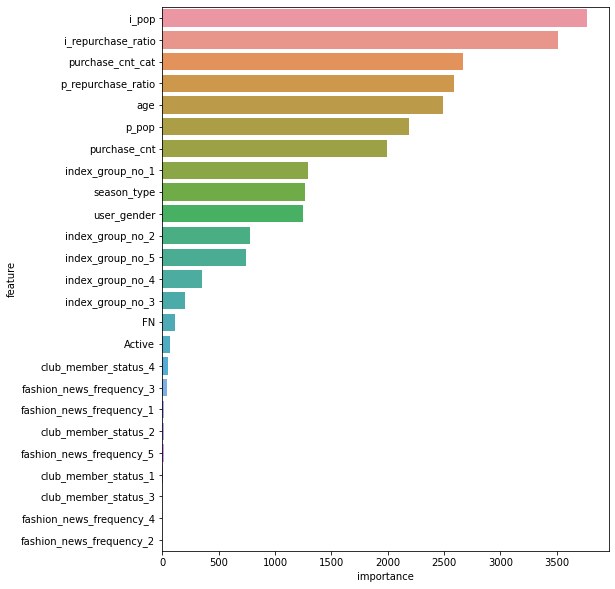

In [ ]:
# train and save the model 
random_ranker, train, test, valid = train_model(inter_rand, 'random', features=features, params=params)

### Part 2. Models with different positive rate.

Model that uses 5% of popular items as candidates (positive rate = 0.56).

In [ ]:
# read all candidates 
full_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"prediction_candidates.pqt")
print(full_candidates.shape)
### Candidates with Time history (5% of candidates) ### 
cand = full_candidates[full_candidates['TimeHistory_1'].notna()]
cand['TimeHistory_1'] = MinMaxScaler().fit_transform(cand['TimeHistory_1'].values.reshape(-1, 1))
n_sample = int(cand.shape[0] * 0.05)
sample=cand.sample(n=n_sample, replace=True, weights='TimeHistory_1', axis=0)[['customer_id', 'week', 'article_id', 'TimeHistory_1', 'score']]
inter_ = sample_generation(sample, inter, 'TimeHistory_1_5perc')
print('positive rate:', inter_.valid.mean())

(34262922, 8)
positive rate: 0.9290216726989241


In [ ]:
inter_ = generate_features_train(inter_)

100%|██████████| 5/5 [00:00<00:00, 41.62it/s]


FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:00<00:00, 10.77it/s]


{'FN': CategoricalDtype(categories=[1, 2], ordered=False), 'Active': CategoricalDtype(categories=[1, 2], ordered=False), 'user_gender': CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False), 'article_gender': CategoricalDtype(categories=[0, 1, 2], ordered=False), 'season_type': CategoricalDtype(categories=[0, 1, 2], ordered=False)}


In [ ]:
inter_.to_parquet(data_dir/"interim"/VERSION_NAME/f"history5_candidates_features.pqt")
print('positive rate:', inter_.valid.mean())

Train positive rate:  0.5634513441878076
Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.856681
[20]	valid_0's auc: 0.866963
[30]	valid_0's auc: 0.870861
[40]	valid_0's auc: 0.870504
[50]	valid_0's auc: 0.879187
[60]	valid_0's auc: 0.869909
[70]	valid_0's auc: 0.867742
[80]	valid_0's auc: 0.864407
Early stopping, best iteration is:
[52]	valid_0's auc: 0.879586


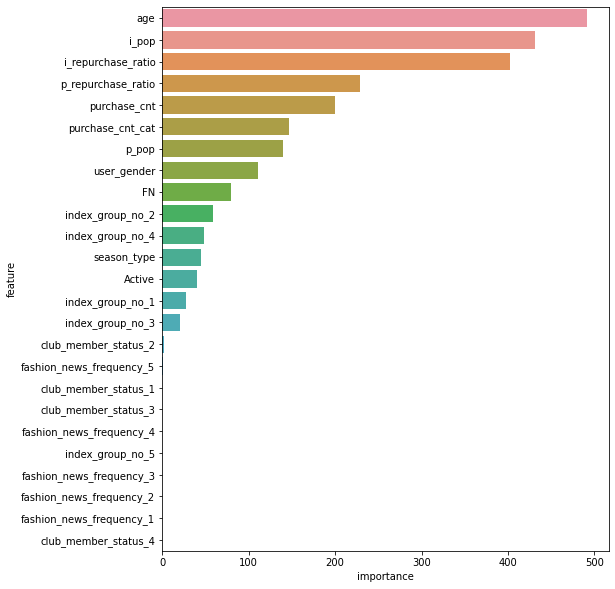

In [ ]:
hist5_ranker, train, test, valid = train_model(inter_, 'hist5', features=features, params=params)

Model that uses 10% of popular items as candidates (positive rate = 0.39).

In [ ]:
# read all candidates 
full_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"prediction_candidates.pqt")
print(full_candidates.shape)
### Candidates with Time history (10% of candidates) ### 
cand = full_candidates[full_candidates['TimeHistory_1'].notna()]
cand['TimeHistory_1'] = MinMaxScaler().fit_transform(cand['TimeHistory_1'].values.reshape(-1, 1))
n_sample = int(cand.shape[0] * 0.1)
sample=cand.sample(n=n_sample, replace=True, weights='TimeHistory_1', axis=0)[['customer_id', 'week', 'article_id', 'TimeHistory_1', 'score']]
inter_ = sample_generation(sample, inter, 'TimeHistory_1_10perc')
print('positive rate:', inter_.valid.mean())


(34262922, 8)


In [ ]:
inter_ = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"history10_candidates_features.pqt")

In [ ]:
inter_ = cat_features_transform(inter_)

 40%|████      | 2/5 [00:00<00:00, 18.34it/s]

FN
Active
user_gender
article_gender


100%|██████████| 5/5 [00:00<00:00, 17.81it/s]


season_type


100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Train positive rate:  0.39341830531768684
Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.822918
[20]	valid_0's auc: 0.823511
[30]	valid_0's auc: 0.85091
[40]	valid_0's auc: 0.85184
[50]	valid_0's auc: 0.861085
[60]	valid_0's auc: 0.870022
[70]	valid_0's auc: 0.879541
[80]	valid_0's auc: 0.877329
[90]	valid_0's auc: 0.877393
[100]	valid_0's auc: 0.884373
[110]	valid_0's auc: 0.88457
[120]	valid_0's auc: 0.893079
[130]	valid_0's auc: 0.89507
[140]	valid_0's auc: 0.906081
[150]	valid_0's auc: 0.909377
[160]	valid_0's auc: 0.909594
[170]	valid_0's auc: 0.909502
[180]	valid_0's auc: 0.908856
[190]	valid_0's auc: 0.908787
[200]	valid_0's auc: 0.908962
Did not meet early stopping. Best iteration is:
[172]	valid_0's auc: 0.910367


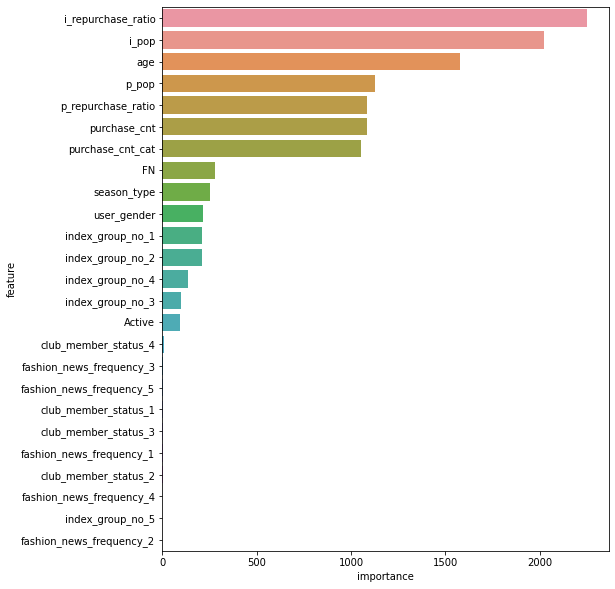

In [ ]:
hist10_ranker, train, test, valid = train_model(inter_, 'hist10', features=features, params=params)

Model that uses 25% of popular items as candidates (positive rate = 0.21).

In [ ]:
# read all candidates 
full_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"prediction_candidates.pqt")
print(full_candidates.shape)
### Candidates with Time history (25% of candidates) ### 
cand = full_candidates[full_candidates['TimeHistory_1'].notna()]
cand['TimeHistory_1'] = MinMaxScaler().fit_transform(cand['TimeHistory_1'].values.reshape(-1, 1))
n_sample = int(cand.shape[0] * 0.25)
sample=cand.sample(n=n_sample, replace=True, weights='TimeHistory_1', axis=0)[['customer_id', 'week', 'article_id', 'TimeHistory_1', 'score']]
inter_ = sample_generation(sample, inter, 'TimeHistory_1_25perc')
print('positive rate:', inter_.valid.mean())


(34262922, 8)
positive rate: 0.7236361881610157


In [ ]:
inter_ = generate_features_train(inter_)

 40%|████      | 2/5 [00:00<00:00, 18.76it/s]

FN
Active
user_gender
article_gender


100%|██████████| 5/5 [00:00<00:00, 15.96it/s]


season_type


100%|██████████| 5/5 [00:01<00:00,  3.98it/s]


{'FN': CategoricalDtype(categories=[1, 2], ordered=False), 'Active': CategoricalDtype(categories=[1, 2], ordered=False), 'user_gender': CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False), 'article_gender': CategoricalDtype(categories=[0, 1, 2], ordered=False), 'season_type': CategoricalDtype(categories=[0, 1, 2], ordered=False)}


In [ ]:
inter_.to_parquet(data_dir/"interim"/VERSION_NAME/f"history25_candidates_features.pqt")
print('positive rate:', inter_.valid.mean())

positive rate: 0.20327432753184


In [ ]:
inter_ = cat_features_transform(inter_)

 40%|████      | 2/5 [00:00<00:00, 18.66it/s]

FN
Active
user_gender
article_gender


100%|██████████| 5/5 [00:00<00:00, 18.25it/s]


season_type


100%|██████████| 5/5 [00:00<00:00, 124.49it/s]


In [ ]:
print('positive rate:', inter_.valid.mean())

positive rate: 0.20327432753184


Train positive rate:  0.20546588600623988
Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.840146
[20]	valid_0's auc: 0.846081
[30]	valid_0's auc: 0.840701
[40]	valid_0's auc: 0.834732
Early stopping, best iteration is:
[15]	valid_0's auc: 0.849892


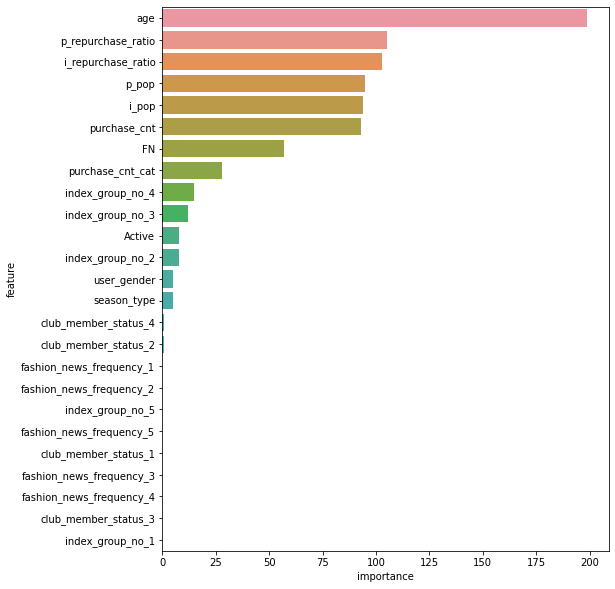

In [ ]:
hist25_ranker, train, test, valid = train_model(inter_, 'hist25', features=features, params=params)

Model that uses 50% of popular items as candidates (positive rate = 0.12).

In [ ]:
# read all candidates 
full_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"prediction_candidates.pqt")
print(full_candidates.shape)
### Candidates with Time history (50% of candidates) ### 
cand = full_candidates[full_candidates['TimeHistory_1'].notna()]
cand['TimeHistory_1'] = MinMaxScaler().fit_transform(cand['TimeHistory_1'].values.reshape(-1, 1))
n_sample = int(cand.shape[0] * 0.5)
sample=cand.sample(n=n_sample, replace=True, weights='TimeHistory_1', axis=0)[['customer_id', 'week', 'article_id', 'TimeHistory_1', 'score']]
inter_ = sample_generation(sample, inter, 'TimeHistory_1_50perc')
print('positive rate:', inter_.valid.mean())


(34262922, 8)
positive rate: 0.5670633918826874


In [ ]:
name = 'TimeHistory_1_50perc'
inter_  = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"{name}_candidates.pqt")

In [ ]:
inter_ = generate_features_train(inter_)

 40%|████      | 2/5 [00:00<00:00, 10.62it/s]

FN
Active
user_gender


 80%|████████  | 4/5 [00:00<00:00,  8.81it/s]

article_gender
season_type


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


{'FN': CategoricalDtype(categories=[1, 2], ordered=False), 'Active': CategoricalDtype(categories=[1, 2], ordered=False), 'user_gender': CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False), 'article_gender': CategoricalDtype(categories=[0, 1, 2], ordered=False), 'season_type': CategoricalDtype(categories=[0, 1, 2], ordered=False)}


In [ ]:
inter_.to_parquet(data_dir/"interim"/VERSION_NAME/f"history50_candidates_features.pqt")
print('positive rate:', inter_.valid.mean())

positive rate: 0.1136589785504028


In [ ]:
inter_ = cat_features_transform(inter_)

 40%|████      | 2/5 [00:00<00:00, 18.66it/s]

FN
Active
user_gender
article_gender


100%|██████████| 5/5 [00:00<00:00, 18.25it/s]


season_type


100%|██████████| 5/5 [00:00<00:00, 124.49it/s]


Train positive rate:  0.11508939007384972
Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.856771
[20]	valid_0's auc: 0.859493
[30]	valid_0's auc: 0.860218
[40]	valid_0's auc: 0.853232
[50]	valid_0's auc: 0.852738
[60]	valid_0's auc: 0.837272
Early stopping, best iteration is:
[36]	valid_0's auc: 0.867341


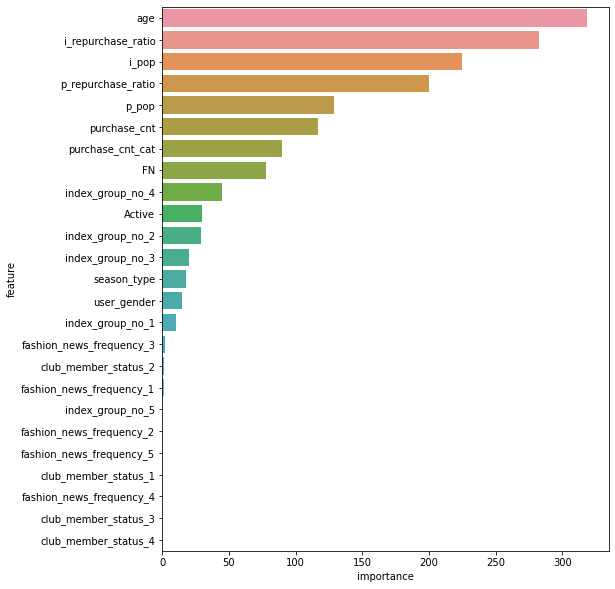

In [ ]:
hist50_ranker, train, test, valid = train_model(inter_, 'hist50', features=features, params=params)

### Part 3. Model trained on the combination of random samples and most popular items. 

In [ ]:
random_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"random_candidates_features.pqt") # read random candidates with features 
history_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"history25_candidates_features.pqt") # read popular candidates (25% of data) with features 
random_candidates = random_candidates[random_candidates['valid'] == 0] # make sure that all random candidates are negative records 

inter_ = pd.concat([random_candidates, history_candidates], ignore_index=True) # combine two datasets with features 
del random_candidates, history_candidates
inter_ = inter_.drop_duplicates(['customer_id', 'article_id', 'week'], keep='first') 

In [ ]:
# I had a lot of issues with memory so I saved to dist most of my intermediate results 
inter_.to_parquet(data_dir/"interim"/VERSION_NAME/f"history25_rand_candidates_features.pqt")
inter_ = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"history25_rand_candidates_features.pqt")

In [ ]:
inter_ = cat_features_transform(inter_)

100%|██████████| 5/5 [00:00<00:00, 38.30it/s]


FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


In [ ]:
print('positive rate:', inter_.valid.mean())

positive rate: 0.18318165035749032


Train positive rate:  0.1852302248447234
Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.836783
[20]	valid_0's auc: 0.829686
[30]	valid_0's auc: 0.825475
Early stopping, best iteration is:
[6]	valid_0's auc: 0.837515


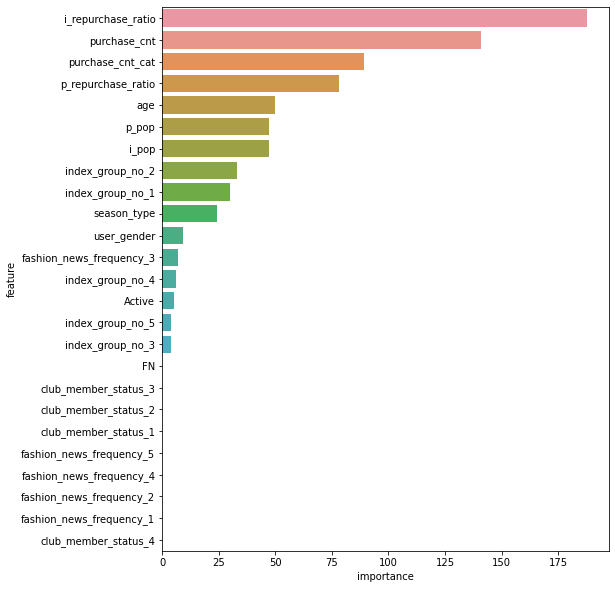

In [ ]:
hist50_rand_ranker, train, test, valid = train_model(inter_, 'hist25_rand', features=features, params=params)

### Part 4. Model trained on the 50% of previously bought items by a user

In [ ]:
# read all candidates 
full_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"prediction_candidates.pqt")
### Candidates with Order history (75% of candidates) ### 
cand = full_candidates[full_candidates['OrderHistory_1'].notna()]
cand['OrderHistory_1'] = MinMaxScaler().fit_transform(cand['OrderHistory_1'].values.reshape(-1, 1))
n_sample = int(cand.shape[0] * 0.75)
sample=cand.sample(n=n_sample, replace=True, weights='OrderHistory_1', axis=0)[['customer_id', 'week', 'article_id', 'OrderHistory_1', 'score']]
inter_ = sample_generation(sample, inter, 'OrderHistory_1_75perc')
print('positive rate:', inter_.valid.mean())


positive rate: 0.9267064832116081


In [ ]:
inter_ = generate_features_train(inter_)

100%|██████████| 5/5 [00:00<00:00, 41.14it/s]


FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:00<00:00, 10.44it/s]


{'FN': CategoricalDtype(categories=[1, 2], ordered=False), 'Active': CategoricalDtype(categories=[1, 2], ordered=False), 'user_gender': CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False), 'article_gender': CategoricalDtype(categories=[0, 1, 2], ordered=False), 'season_type': CategoricalDtype(categories=[0, 1, 2], ordered=False)}


In [ ]:
inter_.to_parquet(data_dir/"interim"/VERSION_NAME/f"order75_candidates_features.pqt")
print('positive rate:', inter_.valid.mean())

positive rate: 0.5556607427629628


In [ ]:
inter_ = cat_features_transform(inter_)

 40%|████      | 2/5 [00:00<00:00, 18.66it/s]

FN
Active
user_gender
article_gender


100%|██████████| 5/5 [00:00<00:00, 18.25it/s]


season_type


100%|██████████| 5/5 [00:00<00:00, 124.49it/s]


Train positive rate:  0.5675235717919294
Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.797501
[20]	valid_0's auc: 0.799132
[30]	valid_0's auc: 0.800654
[40]	valid_0's auc: 0.801591
[50]	valid_0's auc: 0.802656
[60]	valid_0's auc: 0.803876
[70]	valid_0's auc: 0.805253
[80]	valid_0's auc: 0.806431
[90]	valid_0's auc: 0.807453
[100]	valid_0's auc: 0.80904
[110]	valid_0's auc: 0.810542
[120]	valid_0's auc: 0.811496
[130]	valid_0's auc: 0.812043
[140]	valid_0's auc: 0.812587
[150]	valid_0's auc: 0.812928
[160]	valid_0's auc: 0.813258
[170]	valid_0's auc: 0.813655
[180]	valid_0's auc: 0.813937
[190]	valid_0's auc: 0.814149
[200]	valid_0's auc: 0.814257
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.814257


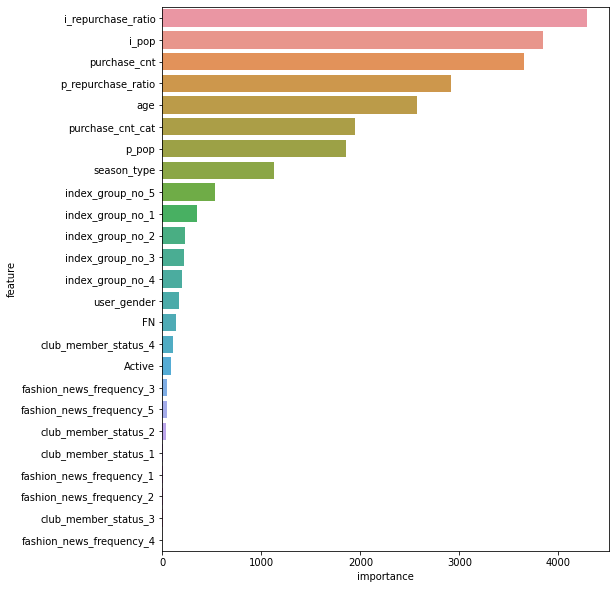

In [ ]:
order75_ranker, train, test, valid = train_model(inter_, 'order75', features=features, params=params)

## Model validation: mean average precision calculation

In [ ]:
def select_n_candidates(res, n, grouped=False, name='score'): 
    """ Rank candidate and select top n.
    Parameters
    ----------
    res : pd.DataFrame
        Dataframe with pairs.
    n : int
        Number of returned candidates.
    grouped : bool, optional
        Whether to group articles for customers in one list, by default ``False``.
    name : String, optional
        Name of a field that is used for ranking, by default ``score``.
    
    Returns
    -------
    pd.DataFrame
        Dataframe with top n candidates for every customer in dataframe.
    """
  res['rank'] = res.groupby('customer_id')[name].rank(ascending=False, method='first')
  res = res[res['rank'] <= n]
  if grouped:
      res = (res.groupby(["customer_id"])['article_id'].apply(list).reset_index())
  return res


#### Baseline

In [ ]:
top12 = select_n_candidates(candidates_test, 12, grouped=True, name='score')
mean_average_precision(y_true=v['article_id'], y_pred=top12['article_id']) ### 0.008126320505691766

0.008126320505691766

### Test on last week 

Prepare all features for models

In [ ]:
### upload real labels for the last week data
full_candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"full_candidates.pqt") # read all the candidates 

week_test = 1
v = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{week_test}_label.pqt") # read real label for the last week 
candidates_test = full_candidates[full_candidates['week'] == week_test] # select only candidates from the last week for validation 
candidates_test = candidates_test[candidates_test['customer_id'].isin(v.customer_id.unique())]
rule_names = ['UGTimeHistory_1', 'OrderHistory_1', 'TimeHistory_1', 'Random']
candidates_test = candidates_test[rule_names + ['score', 'week', 'customer_id', 'article_id']][candidates_test['score'] >= 0]
v = (v.groupby(["customer_id"])['article_id'].apply(list).reset_index())

In [ ]:
# inter_test = sample_generation(candidates_test, inter, 'test') # create test_candidates.pqt file with all the predictors 
inter_test = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"test_candidates.pqt")

In [ ]:
inter_test = generate_features_train(inter_test)

 40%|████      | 2/5 [00:00<00:00, 17.00it/s]

FN
Active
user_gender


100%|██████████| 5/5 [00:00<00:00, 14.64it/s]


article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


{'FN': CategoricalDtype(categories=[1, 2], ordered=False), 'Active': CategoricalDtype(categories=[1, 2], ordered=False), 'user_gender': CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False), 'article_gender': CategoricalDtype(categories=[0, 1, 2], ordered=False), 'season_type': CategoricalDtype(categories=[0, 1, 2], ordered=False)}


In [ ]:
inter_test = inter_test[inter_test['week'] == 1]
inter_test = inter_test.merge(candidates_test, how='right')
inter_test.to_parquet(data_dir/"processed"/"test_week1.pqt")

In [ ]:
inter_test = pd.read_parquet(data_dir/"processed"/"test_week1.pqt")

In [ ]:
inter_test = cat_features_transform(inter_test)

 40%|████      | 2/5 [00:00<00:00, 18.10it/s]

FN
Active
user_gender
article_gender


100%|██████████| 5/5 [00:00<00:00, 16.71it/s]


season_type


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


In [ ]:
# read all the rankers
ranker_random = lgb.Booster(model_file=model_dir/"lgb_large_ranker_random.model")
hist5_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist5.model")
hist10_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist10.model")

hist25_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist25.model")
hist50_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist50.model")
order75_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_order75.model")
hist25_rand_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist25_rand.model")


In [ ]:
# run prediction wuth all the models
inter_test['pred_random'] = ranker_random.predict(inter_test[features])
inter_test['pred_hist5'] = hist5_ranker.predict(inter_test[features])
inter_test['pred_hist10'] = hist10_ranker.predict(inter_test[features])

inter_test['pred_hist25'] = hist25_ranker.predict(inter_test[features])
inter_test['pred_hist50'] = hist50_ranker.predict(inter_test[features])
inter_test['pred_order75'] = order75_ranker.predict(inter_test[features])
inter_test['pred_hist25_rand'] = hist25_rand_ranker.predict(inter_test[features])

In [ ]:
inter_test[['t_dat', 'customer_id', 'article_id', 'week', 'valid', 'ALS_1', 'ItemCF_2', 'OrderHistoryDecay_1',
       'OrderHistory_1', 'Random', 'TimeHistory_1', 'UGItemCF_2', 'UGItemCF_5',
       'UGTimeHistory_1', 'UGTimeHistory_2', 'product_code', 'index_group_no',
       'pred_random', 'pred_hist5', 'pred_hist10', 'pred_hist25', 'pred_hist50', 'pred_order75',
       'pred_hist25_rand']].to_parquet(data_dir/"processed"/"test_week1_predictions.pqt")

In [ ]:
inter_test = pd.read_parquet(data_dir/"processed"/"test_week1_predictions.pqt")

In [ ]:
# MAP@12 calculation 
cols = ['pred_hist5', 'pred_hist10', 'pred_hist25', 'pred_hist50', 'pred_order75', 'pred_hist25_rand']
for c in cols:
    print("Column ", c)
    top12 = select_n_candidates(inter_test, 12, grouped=True, name=c)
    print(mean_average_precision(y_true=v['article_id'], y_pred=top12['article_id']))

Column  pred_hist5
0.016116427013901303
Column  pred_hist10
0.02138379995715326
Column  pred_hist25
0.011388290413269402
Column  pred_hist50
0.013060768364794452
Column  pred_order75
0.03194610404785537
Column  pred_hist25_rand
0.026796367783330916


In [ ]:
# MAP@12 calculation for random model
top12 = select_n_candidates(inter_test[['customer_id', 'article_id', 'week', 'valid', 'pred_random']], 12, grouped=True, name='pred_random')
mean_average_precision(y_true=v['article_id'], y_pred=top12['article_id']) ### 0.029127774542093275

0.029127774542093275

### Experiments with model stacking 

In [ ]:
# calculate score based only on four candidate generation strategies 
rule_names = ['UGTimeHistory_1', 'OrderHistory_1', 'TimeHistory_1', 'Random']
tmp = inter_test[rule_names]
for f in rule_names:
    tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
inter_test['score'] = tmp[rule_names].sum(axis=1)

Combined model #1

In [ ]:
# calculate combined score as a sum of scaled values from 7 models and score from candidate generation  - combined_score
cols = ['pred_random', 'pred_hist5', 'pred_hist10', 'pred_hist25', 'pred_hist50', 'pred_order75',
       'pred_hist25_rand', 'score']
tmp = inter_test[cols]
for f in cols:
    tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
inter_test['combined_score'] = tmp[cols].sum(axis=1)

In [ ]:
# MAP@12 calculation for combined_score
top12 = select_n_candidates(inter_test, 12, grouped=True, name='combined_score')
print(mean_average_precision(y_true=v['article_id'], y_pred=top12['article_id']))

0.02679934296219727


Combined model #2

In [ ]:
# calculate combined score as a sum of scaled values from 4 models and score from candidate generation  - combined_score_hist10only
# from history models only one is included - pred_hist10 - because there is high correlation between all scoring from models trained on history
cols = ['pred_random', 'pred_hist10', 'pred_hist25_rand', 'pred_order75', 'score']
tmp = inter_test[cols]
for f in cols:
    tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
inter_test['combined_score_hist10only'] = tmp[cols].sum(axis=1)

In [ ]:
top12 = select_n_candidates(inter_test, 12, grouped=True, name='combined_score_hist10only')
print(mean_average_precision(y_true=v['article_id'], y_pred=top12['article_id']))

0.025075789063407378


Combined model #3

In [ ]:
# calculate combined score as a mean value of scaled values from 4 models withour score from candidate generation  - combined_score_mean
cols = ['pred_random', 'pred_hist10', 'pred_order75', 'pred_hist25_rand']
tmp = inter_test[cols]
for f in cols:
    tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
inter_test['combined_score_mean'] = tmp[cols].mean(axis=1)
# then additionally add score from candidate generation - combined_score_imp
inter_test['combined_score_imp'] = inter_test[['combined_score_mean', 'score']].sum(axis=1)

In [ ]:
top12 = select_n_candidates(inter_test, 12, grouped=True, name='combined_score_imp')
print(mean_average_precision(y_true=v['article_id'], y_pred=top12['article_id']))

0.023413342685100577


Analyses of combined models 

In [ ]:
cols = ['OrderHistory_1', 'Random', 'TimeHistory_1', 'UGTimeHistory_1', 
       'pred_random', 'pred_hist5', 'pred_hist10', 'pred_hist25', 'pred_hist50', 'pred_order75',
       'pred_hist25_rand', 'score', 'combined_score',
       'combined_score_hist10only',
       'combined_score_imp',]

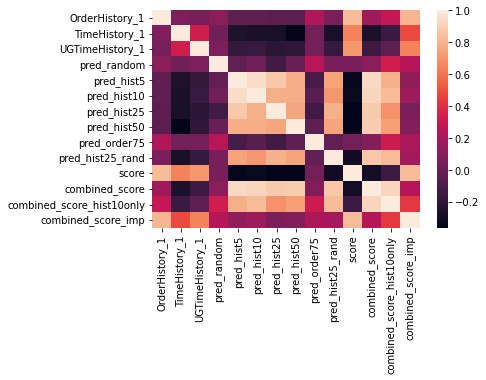

In [ ]:
sns.heatmap(inter_test[cols].corr())

### Validation on Kaggle data

In [ ]:
def parse(x):
    """ Add '0' to article_ids for Kaggle submission and transformation to a string.
    Parameters
    ----------
    x : List
        List of articles.
    Returns
    -------
    String
        String with 12 articles for Kaggle submission.
    """
    l = ['0' + str(i) for i in x]
    l = ' '.join(l[:12])
    return l

def create_submission_file(subm, column_name, file_name, data_dir):
    """ Create a file for Kaggle submission.
    Parameters
    ----------
    subm : pd.DataFrame
        Dataframe with sample submission.
    column_name : String
        Name of a columnn with predictions.
    file_name : String
        Name of a submission file.
    data_dir : Path
        Path to a folder to save a submission file.
    Returns
    -------
    """
    idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb")) # read mapping from custom ids to Kaggle ids
    subm['customer_id'] = subm['customer_id'].map(idx2uid) # apply mapping 
    subm['prediction'] = subm[column_name].apply(lambda x: parse(x))
    subm[['customer_id', 'prediction']].to_csv(data_dir/f"submission_{file_name}.zip", compression={'method': 'zip', 'archive_name': 'submission_' + str(file_name) + '.csv'}, index=False)

Part 1 - first three models as rankers and baseline

In [ ]:
ranker_random = lgb.Booster(model_file=model_dir/"lgb_large_ranker_random.model")
hist5_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist5.model")
hist10_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist10.model")

In [ ]:
week=0

item_idx2uid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb")) # mapping 
subm = pd.DataFrame(columns=['customer_id', 'article_id', 'score', 'random_article', 'hist5_article', 'hist10_article']) # sample submission

for batch in range(0, len(submission.customer_id), batch_size):
    print(batch)
    candidates_valid = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_batch{batch}_candidate_features.pqt") # read candidates for a batch
    # calculate score based on 4 strategies 
    rule_names = ['UGTimeHistory_1', 'OrderHistory_1', 'TimeHistory_1', 'Random']
    tmp = candidates_valid[rule_names]
    for f in rule_names:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    candidates_valid['score'] = tmp[rule_names].sum(axis=1)
    # select candidates only with one of 4 strategies 
    candidates_valid = candidates_valid[(candidates_valid['UGTimeHistory_1'].notna()) | (candidates_valid['OrderHistory_1'].notna()) |
                        (candidates_valid['TimeHistory_1'].notna()) | (candidates_valid['Random'].notna())]
    
    candidates_valid["article_id"] = candidates_valid["article_id"].map(item_idx2uid)
    # transform categorical features
    candidates_valid = cat_features_transform(candidates_valid)
    
    # model predictions 
    candidates_valid['pred_random'] = ranker_random.predict(candidates_valid[features])
    candidates_valid['pred_hist5'] = hist5_ranker.predict(candidates_valid[features])
    candidates_valid['pred_hist10'] = hist10_ranker.predict(candidates_valid[features])
    
    # top12 best products
    top12_baseline = select_n_candidates(candidates_valid, 12, grouped=True, name='score') # baseline model - without additional ranker 
    top12_random = select_n_candidates(candidates_valid, 12, grouped=True, name='pred_random') # random model 

    top12_baseline['random_article'] = top12_random['article_id'] # add a column to top12_baseline with random predictions 
    del top12_random # to save memory 

    top12_hist5 = select_n_candidates(candidates_valid, 12, grouped=True, name='pred_hist5')
    top12_baseline['hist5_article'] = top12_hist5['article_id'] # add a column to top12_baseline with predictions from a model 
    del top12_hist5

    top12_hist10 = select_n_candidates(candidates_valid, 12, grouped=True, name='pred_hist10')
    top12_baseline['hist10_article'] = top12_hist10['article_id'] # add a column to top12_baseline with predictions from a model
    del top12_hist10

    subm = subm.append(top12_baseline)
    candidates_valid[['article_id', 'customer_id', 'score', 'pred_random', 'pred_hist5', 'pred_hist10']].to_parquet(data_dir/"interim"/VERSION_NAME/f"week0_batch{batch}_predictions.pqt") # save results

0


 60%|██████    | 3/5 [00:00<00:00, 22.73it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


100000


 60%|██████    | 3/5 [00:00<00:00, 20.88it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


200000


 60%|██████    | 3/5 [00:00<00:00, 17.76it/s]

FN
Active
user_gender
article_gender


100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


season_type


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


300000


 60%|██████    | 3/5 [00:00<00:00, 22.46it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


400000


 60%|██████    | 3/5 [00:00<00:00, 17.91it/s]

FN
Active
user_gender
article_gender


100%|██████████| 5/5 [00:00<00:00, 19.70it/s]


season_type


100%|██████████| 5/5 [00:01<00:00,  4.27it/s]


500000


 40%|████      | 2/5 [00:00<00:00, 14.36it/s]

FN
Active
user_gender


100%|██████████| 5/5 [00:00<00:00, 11.39it/s]


article_gender
season_type


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


600000


 60%|██████    | 3/5 [00:00<00:00, 22.29it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


700000


 60%|██████    | 3/5 [00:00<00:00, 21.06it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.02it/s]


800000


 40%|████      | 2/5 [00:00<00:00, 19.86it/s]

FN
Active
user_gender
article_gender


100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


season_type


100%|██████████| 5/5 [00:01<00:00,  4.08it/s]


900000


 60%|██████    | 3/5 [00:00<00:00, 22.84it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


1000000


 60%|██████    | 3/5 [00:00<00:00, 21.76it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


1100000


 60%|██████    | 3/5 [00:00<00:00, 19.68it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


1200000


 60%|██████    | 3/5 [00:00<00:00, 22.51it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


1300000


100%|██████████| 5/5 [00:00<00:00, 27.67it/s]


FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


In [ ]:
subm.to_parquet(data_dir/"interim"/VERSION_NAME/f"week0_batch_all_predictions_top12_part1.pqt")

In [ ]:
# create submission files
create_submission_file(subm[['customer_id', 'article_id']], 'article_id', 'baseline', data_dir)
create_submission_file(subm[['customer_id', 'random_article']], 'random_article', 'random', data_dir)
create_submission_file(subm[['customer_id', 'hist5_article']], 'hist5_article', 'hist5', data_dir)
create_submission_file(subm[['customer_id', 'hist10_article']], 'hist10_article', 'hist10', data_dir)


Part 2 - other four models as rankers

In [ ]:
hist25_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist25.model")
hist50_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist50.model")
order75_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_order75.model")
hist25_rand_ranker = lgb.Booster(model_file=model_dir/"lgb_large_ranker_hist25_rand.model")

In [ ]:
# validation model, part 2: four models as rankers
week=0

item_idx2uid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))
subm = pd.DataFrame(columns=['customer_id', 'article_id', 'hist50_article', 'order75_article', 'mixed_article'])
# len(submission.customer_id)
for batch in range(0, len(submission.customer_id), batch_size):
    print(batch)
    candidates_valid = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_batch{batch}_candidate_features.pqt")
    candidates_valid = candidates_valid[(candidates_valid['UGTimeHistory_1'].notna()) | (candidates_valid['OrderHistory_1'].notna()) |
                        (candidates_valid['TimeHistory_1'].notna()) | (candidates_valid['Random'].notna())]
    candidates_valid["article_id"] = candidates_valid["article_id"].map(item_idx2uid)
    # transform categorical features
    candidates_valid = cat_features_transform(candidates_valid)
    
    # model predictions 
    candidates_valid['pred_hist25'] = hist25_ranker.predict(candidates_valid[features])
    candidates_valid['pred_hist50'] = hist50_ranker.predict(candidates_valid[features])
    candidates_valid['pred_order75'] = order75_ranker.predict(candidates_valid[features])
    candidates_valid['pred_hist25_rand'] = hist25_rand_ranker.predict(candidates_valid[features])
    
    # top12 best products
    top12_baseline = select_n_candidates(candidates_valid, 12, grouped=True, name='pred_hist25')
    top12_1 = select_n_candidates(candidates_valid, 12, grouped=True, name='pred_hist50')

    top12_baseline['hist50_article'] = top12_1['article_id']
    del top12_1

    top12_2 = select_n_candidates(candidates_valid, 12, grouped=True, name='pred_order75')
    top12_baseline['order75_article'] = top12_2['article_id']
    del top12_2

    top12_3 = select_n_candidates(candidates_valid, 12, grouped=True, name='pred_hist25_rand')
    top12_baseline['mixed_article'] = top12_3['article_id']
    del top12_3

    subm = subm.append(top12_baseline)
    candidates_valid[['article_id', 'customer_id', 'pred_hist25', 'pred_hist50', 'pred_order75', 'pred_hist25_rand']].to_parquet(data_dir/"interim"/VERSION_NAME/f"week0_batch{batch}_part2_predictions.pqt")

0


 60%|██████    | 3/5 [00:00<00:00, 19.36it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


100000


 60%|██████    | 3/5 [00:00<00:00, 22.88it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.02it/s]


200000


 60%|██████    | 3/5 [00:00<00:00, 22.07it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


300000


 60%|██████    | 3/5 [00:00<00:00, 21.10it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


400000


 60%|██████    | 3/5 [00:00<00:00, 22.08it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


500000


 60%|██████    | 3/5 [00:00<00:00, 22.16it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


600000


 60%|██████    | 3/5 [00:00<00:00, 22.82it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


700000


 60%|██████    | 3/5 [00:00<00:00, 22.80it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


800000


 40%|████      | 2/5 [00:00<00:00, 12.15it/s]

FN
Active
user_gender


100%|██████████| 5/5 [00:00<00:00, 15.74it/s]


article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.64it/s]


900000


 60%|██████    | 3/5 [00:00<00:00, 23.41it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


1000000


 60%|██████    | 3/5 [00:00<00:00, 23.25it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


1100000


 60%|██████    | 3/5 [00:00<00:00, 19.82it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


1200000


 60%|██████    | 3/5 [00:00<00:00, 22.47it/s]

FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


1300000


100%|██████████| 5/5 [00:00<00:00, 32.34it/s]


FN
Active
user_gender
article_gender
season_type


100%|██████████| 5/5 [00:00<00:00,  5.87it/s]


In [ ]:
subm.to_parquet(data_dir/"interim"/VERSION_NAME/f"week0_batch_all_predictions_top12_part2.pqt")

In [ ]:
# create submission files
create_submission_file(subm[['customer_id', 'article_id']], 'article_id', 'hist25', data_dir)
create_submission_file(subm[['customer_id', 'hist50_article']], 'hist50_article', 'hist50', data_dir)
create_submission_file(subm[['customer_id', 'order75_article']], 'order75_article', 'order75', data_dir)
create_submission_file(subm[['customer_id', 'mixed_article']], 'mixed_article', 'mixed_rand_hist25', data_dir)


Part 3 - validation of stacking models 

In [ ]:

week=0
subm = pd.DataFrame()

for batch in range(0, len(submission.customer_id), batch_size):
    print(batch)    
    # read data 
    cand1 = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week0_batch{batch}_predictions.pqt")
    cand2 = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week0_batch{batch}_part2_predictions.pqt")
    # combine two dataframes 
    cand1[['pred_hist25', 'pred_hist50', 'pred_order75', 'pred_hist25_rand']] = cand2[['pred_hist25', 'pred_hist50', 'pred_order75', 'pred_hist25_rand']]
    
    # calculate combined_score (first stacking model)
    cols = ['pred_random', 'pred_hist5', 'pred_hist10', 'pred_hist25', 'pred_hist50', 'pred_order75',
          'pred_hist25_rand', 'score']
    tmp = cand1[cols]
    for f in cols:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    cand1['combined_score'] = tmp[cols].sum(axis=1)


    # calculate combined_score_hist10only  (second stacking model)
    cols = ['pred_random', 'pred_hist10', 'pred_hist25_rand', 'pred_order75', 'score']
    tmp = cand1[cols]
    for f in cols:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    cand1['combined_score_hist10only'] = tmp[cols].sum(axis=1)

    # calculate combined_score_imp  (third stacking model)
    cols = ['pred_random', 'pred_hist10', 'pred_order75', 'pred_hist25_rand']
    tmp = cand1[cols]
    for f in cols:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    cand1['combined_score_mean'] = tmp[cols].mean(axis=1)
    cand1['combined_score_imp'] = cand1[['combined_score_mean', 'score']].sum(axis=1)

    # select top 12 articles for customers 
    top12_1 = select_n_candidates(cand1, 12, grouped=True, name='combined_score')
    top12_2 = select_n_candidates(cand1, 12, grouped=True, name='combined_score_hist10only')
    top12_3 = select_n_candidates(cand1, 12, grouped=True, name='combined_score_imp')

    top12_1['combined_score_hist10only'] = top12_2['article_id']
    top12_1['combined_score_imp'] = top12_3['article_id']

    subm = subm.append(top12_1)


0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000


In [ ]:
# create submission for stacking models 
create_submission_file(subm[['customer_id', 'article_id']], 'article_id', 'combined_score', data_dir)
create_submission_file(subm[['customer_id', 'combined_score_hist10only']], 'combined_score_hist10only', 'combined_score_hist10only', data_dir)
create_submission_file(subm[['customer_id', 'combined_score_imp']], 'combined_score_imp', 'combined_score_imp', data_dir)
